In [0]:
%pip install pygame pandas matplotlib noise deltalake pyspark==2.1.2 pyarrow==11.0.0 plotly
#%pip uninstall pyarrow
#%pip install pyarrow==15.0.2
#%pip install pyarrow==16  # Or use a compatible version like 11.0.0
#dbutils.library.restartPython()
#%pip install deltalake==0.9.2  # Ensure `deltalake` is compatible with `pyarrow`
# %pip install mosaicml
# %pip list
#dbutils.library.restartPython()


  Obtaining dependency information for pygame from https://files.pythonhosted.org/packages/7a/a1/9ae2852ebd3a7cc7d9ae7ff7919ab983e4a5c1b7a14e840732f23b2b48f6/pygame-2.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/132.0 kB ? eta -:--:--
     ━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/132.0 kB 1.5 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for deltalake from https://files.pythonhosted.org/packages/7c/09/95abe066d746fb3be6c74dce78f3c847edf8b274062fb73b0b5afdae3d8f/deltalake-0.22.3-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/181.3 MB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.5/181.3 MB 13.6 MB/s eta 0:00:14
     ━━━━━━━━━━━━━━━━━━━━━

In [0]:
"""
MIT License

Copyright (c) 2020 Ben Plate 

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

"""

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"  # Run pygame without opening a display window
import sys

import pygame
import pygame.gfxdraw
import math
import noise

import random
import pandas as pd
from datetime import datetime

import numpy as np
from pyspark.sql import SparkSession
import mlflow
from delta.tables import DeltaTable
from deltalake.writer import write_deltalake  # use delta-rs or similar lightweight Delta Lake

mlflow.end_run()
# Start Spark Session for Delta Lake (this code should be within a Databricks notebook)
spark = SparkSession.builder \
    .appName("Empire Simulation") \
    .getOrCreate()

# Start MLflow
mlflow.set_tracking_uri("databricks")  # Set Databricks as tracking URI
mlflow.start_run(run_name="Empire Performance Comparison")

# Define Delta Lake Table for Empire Metrics
#delta_lake_path = "/dbfs/empire_data/newmetrics"  # Databricks file path for Delta table
delta_table_path = "/dbfs/empire_data/territorymetrics"  # Databricks file path for Delta table
# Initialize the Delta table schema
columns = ["empire_name", "age", "territory_size", "economy", "stability", "x", "y"]
empire_metrics_df = spark.createDataFrame([columns], schema=columns)  # Empty DataFrame for schema

# Save Delta table (first-time creation)
empire_metrics_df.write.format("delta").mode("overwrite").save(delta_table_path)

# Function to log and save metrics for each empire
# def log_metrics_to_delta_lake(empire, path=delta_lake_path):
#     # Convert metrics to a DataFrame or dictionary
#     metrics_data = pd.DataFrame([{
#         "empire_name": empire.name,
#         "age": empire.age,
#         "territory_size": len(get_empire_tiles(empire)),
#         "economy": empire.economy,
#         "stability": empire.stability 
#     }])
#     # Write to Delta Lake path
#     write_deltalake(path, metrics_data, mode="append")  # No Spark session needed
def log_and_save_metrics(empire):
    """Logs metrics for each empire to MLflow and saves to Delta Lake."""
    # Extract empire metrics
    territory_tiles = get_empire_tiles(empire)
    metrics = [
        ("empire_name", empire.name),  # Include empire name for comparison
        ("age", empire.age),
        ("territory_size", len(get_empire_tiles(empire))),
       ( "economy", empire.economy),
        ("stability", empire.stability)
    ]

    # Log to MLflow with empire name
    mlflow.log_metric(f"{metrics[0][1]}_age", metrics[1][1])
    mlflow.log_metric(f"{metrics[0][1]}_territory_size", metrics[2][1])
    mlflow.log_metric(f"{metrics[0][1]}_economy", metrics[3][1])
    mlflow.log_metric(f"{metrics[0][1]}_stability", metrics[4][1])

      # Include individual tile coordinates
    tile_data = [
        (empire.name, empire.age, len(get_empire_tiles(empire)), empire.economy, empire.stability, tile.x, tile.y)
        for tile in territory_tiles
    ]

    # Define columns for the DataFrame
    columns = [
        "empire_name", "age", "territory_size", "economy",  "stability", "x", "y"
    ]

    # Handle empty tile_data
    if not tile_data:
        print("No data to log; skipping metrics update.")
        return
    # Convert metrics to a DataFrame
    metrics_df = spark.createDataFrame(tile_data, columns)

    # Append or merge into Delta table
    delta_table = DeltaTable.forPath(spark, delta_table_path)
    delta_table.alias("old_data").merge(
        metrics_df.alias("new_data"),
        """
        old_data.x = new_data.x AND 
        old_data.y = new_data.y AND
        old_data.empire_name = new_data.empire_name
        """
    ).whenNotMatchedInsertAll().execute()

seed_value = int(datetime.now().timestamp())  # Get the current time as a float
random.seed(seed_value)
# random.seed(datetime.now())

rand_val = random.randint(0, 100000)

SQRT_3 = 1.732
WINDOW_BOUND = [1366, 700]
GAME_BOUND = [
    round(WINDOW_BOUND[0] * 1 / 64),
    round(WINDOW_BOUND[1] * 1 / 64),
    round(WINDOW_BOUND[0] * 31 / 32),
    round(WINDOW_BOUND[1] * 31 / 32),
]
HEX_WIDTH = 12  # 12
DIMENSIONS = [64, 32]  # 64, 32
CONTINENT_ROUGHNESS = 0.9  # 0.9
OCEAN_WORLD = 5
INITIAL_EMPIRES = 16  # 16
PEACE_DURATION = 15
ECONOMIC_ADVANTAGE = 2
ENABLE_MULTITHREADING = True

NUM_CORES = 1

if ENABLE_MULTITHREADING:
    if sys.platform.startswith("linux"):
        stream = os.popen("grep -c ^processor /proc/cpuinfo")
    elif sys.platform.startswith("win"):
        stream = os.popen("echo %NUMBER_OF_PROCESSORS%")
    elif sys.platform.startswith("cygwin"):
        stream = os.popen("echo %NUMBER_OF_PROCESSORS%")
    elif sys.platform.startswith("msys"):
        stream = os.popen("echo %NUMBER_OF_PROCESSORS%")
    elif sys.platform.startswith("darwin"):
        stream = os.popen("sysctl -n hw.ncpu")

    output = stream.read()
    NUM_CORES = int(output[: len(output) - 1])

global emp_count, game_tick, turn

noise_vals = []
emp_arr = []
hex_arr = []
emp_count = 1
game_tick = 1
turn = 1


class Empire:
    def __init__(self, name, capital, color, economy=100):
        global emp_count

        self.name = name
        self.capital = capital
        self.color = verify_color(color)
        self.expanding = True
        self.economy = economy
        self.stability = 1.0
        self.war_targets = []
        self.peace_deals = []
        self.border_emps = []
        self.border_count = 0
        self.age = 0

        emp_count += 1
        annex_tile(self, capital)
        # self.capital.set_color((0, 0, 0))
        self.capital.make_capital()
        emp_arr.append(self)

        recalc_border_emps(self)

        for border_emp in self.border_emps:
            recalc_border_emps(border_emp)


class AIEmpire(Empire):
    def __init__(self, name, capital, color, economy=100, ai_agent=None):
        super().__init__(name, capital, color, economy)
        self.ai_agent = ai_agent  # Reinforcement learning agent

        self.reward = 0
        self.state = self.get_state()
        self.next_state = None
        self.expanding = True
        annex_tile(self, capital)
        self.capital.make_capital()
        # emp_arr.append(self)

        recalc_border_emps(self)

        for border_emp in self.border_emps:
            recalc_border_emps(border_emp)
        # recalc_border_emps(self)

        # for border_emp in self.border_emps:
        #     recalc_border_emps(border_emp)

    def get_state(self):
        """Define the state representation for the AI agent."""
        return {
            "economy": self.economy,
            "stability": self.stability,
            "territory_size": len(get_empire_tiles(self)),
            "border_empires": len(self.border_emps),
            "age": self.age,
        }

    def update_reward(self):
        """Update the reward based on the empire's performance."""
        territory_growth = len(get_empire_tiles(self)) - self.state["territory_size"]
        self.reward = (
            territory_growth * 10  # Reward for each tile acquired
            + (self.economy - self.state["economy"]) * 0.1  # Reward for economy growth
            - (5 - self.stability) * 5  # Penalty for low stability
        )

    def take_action(self):
        """Allow the AI agent to choose an action based on the current state."""
        self.state = self.get_state()
        action = self.ai_agent.select_action(self.state, self.next_state, self.reward)[
            0
        ]
        q_value = self.ai_agent.select_action(self.state, self.next_state, self.reward)[
            1
        ]
        # print(self.state["economy"], self.state["territory_size"], self.war_targets)
        # print(action)
        # Define actions (expand, declare war, improve stability, etc.)
        if action == "expand":
            self.expand_territory()
        elif action == "declare_war":
            self.declare_war_on_neighbor()
        elif action == "stabilize":
            self.improve_stability()
        elif action == "peace":
            self.make_peace_with_neighbor()
        elif action == "sea_invade":
            self.sea_invade()
        self.next_state = self.get_state()  # update next_state for simulation
        self.update_reward()  # Update the reward after taking action
        # log_metrics(
        #     turn,
        #     self.name,
        #     self.economy,
        #     self.stability,
        #     self.state["territory_size"],
        #     self.reward,
        #     action,
        #     q_value,
        # )

    def process_turn(self):
        tiles = get_empire_tiles(self)

        # print(self.economy)

        # border_selfs = []
        deltaE = math.floor(
            (
                2.5 * len(tiles)
                + (
                    len(tiles) < 20
                    and 250
                    or (250 + -0.55 * ((len(tiles) - 20) ** 1.3))
                )
                / 3
            )
            / (len(self.war_targets) + 1)
        )
        deltaS = 1.0 - (len(tiles) + 1) * 0.02
        if deltaE > 750:
            deltaE = 750
        if deltaS > 0.5:
            deltaS = 0.5
        if deltaS < -0.5:
            deltaS = -0.5
        self.economy += deltaE
        self.stability += deltaS
        if self.economy > 500000:
            self.economy = 500000
        if self.economy < 0:
            self.economy = 0
        if self.stability > 5:
            self.stability = 5.0
        if self.stability < 0:
            self.stability = 0.0

        if len(tiles) == 1:
            surrounded = True
            surroundings = get_surroundings(self.capital)
            if len(surroundings) == 0:
                dissolve_empire(self)
            else:
                surrounding_emp = surroundings[0].empire
                for surr_hex in surroundings:
                    if surr_hex.empire != surrounding_emp:
                        surrounded = False
                        break
                if surrounded == True:
                    if surrounding_emp is not None:
                        partition_empire(self, surrounding_emp)
                    else:
                        print(
                            f"Warning: Cannot partition {self.name} as there is no surrounding empire."
                        )
        if (
            random.randint(
                min(round(self.border_count / (1 + len(tiles))) * 200, 1000), 2000
            )
            == 2000
        ):
            print("%s collapsed!" % (self.name))
            dissolve_empire(self)
        # Tile occupation and bordering empire checks
        # Recalculate borders, etc.
        # Rebellion chance based on distance and stability
        if len(self.war_targets) == 0:
            for i in range(0, 3):
                rand_hex = hex_arr[random.randint(0, len(hex_arr) - 1)]
                if (
                    rand_hex.empire == self
                    and rand_hex.occupier is None
                    and random.randint(math.floor(min(self.stability, 0.9) * 10), 10)
                    < 5
                    and distance_from_tiles(self.capital, rand_hex) > 8
                    and random.randint(
                        0, 25 + math.floor(distance_from_tiles(self.capital, rand_hex))
                    )
                    > 25
                ):
                    print("A nation has rebelled against %s! (2)" % (self.name))
                    rebel(self, rand_hex)
                    self.stability *= 0.5
                    if random.randint(0, 2) == 0 and len(tiles) > 30:
                        the_tiles = get_empire_tiles(self)
                        rand_hex = the_tiles[random.randint(0, len(the_tiles) - 1)]
                        for i in range(0, random.randint(1, 3)):
                            rebel(self, rand_hex)
                        self.stability *= 0.5
                        print("%s has broken out into civil war!" % (self.name))
                    break
        self.age += 1

    def expand_territory(self):
        """Try to expand territory if possible."""
        action_taken = False
        for hexagon in get_empire_tiles(self):
            surroundings = get_surroundings(hexagon)
            for surr_hex in surroundings:
                if surr_hex.empire is None and surr_hex.occupier is None:
                    annex_tile(self, surr_hex)
                    recalc_border_emps(self)
                    action_taken = True
                    break
        for hexagon in get_controlled_tiles(self):
            surroundings = get_surroundings(hexagon)
            for surr_hex in surroundings:
                if not is_in_control(self, surr_hex):
                    for target in self.war_targets:
                        if (
                            target.type == 0
                            and is_in_control(target.target, surr_hex)
                            and (
                                surr_hex.empire == target.target
                                or surr_hex.empire == self
                            )
                        ):
                            econ_advantage = min(
                                round(self.economy / (target.target.economy + 1)), 9
                            )
                            helpers = 0
                            destroyed_empire = False
                            for pot_helper in get_surroundings(surr_hex):
                                if is_in_control(self, pot_helper):
                                    helpers += 1
                            if (
                                target.rebel is None
                                and random.randint(0, helpers + 1) > 1
                                and random.randint(
                                    0, econ_advantage * ECONOMIC_ADVANTAGE + 1
                                )
                                > 1
                            ):
                                if surr_hex.empire == self:
                                    unoccupy_tile(surr_hex)
                                else:
                                    destroyed_empire = occupy_tile(
                                        self, surr_hex, target
                                    )
                                    action_taken = True
                            elif (
                                target.rebel == True
                                and random.randint(0, helpers + 1) > 1
                                and random.randint(0, 3) == 0
                            ):
                                if surr_hex.empire == self:
                                    unoccupy_tile(surr_hex)
                                else:
                                    destroyed_empire = occupy_tile(
                                        self, surr_hex, target
                                    )
                                    action_taken = True
                            elif (
                                target.rebel == False
                                and random.randint(0, helpers + 1) > 1
                                and random.randint(0, 10) == 0
                            ):
                                if surr_hex.empire == self:
                                    unoccupy_tile(surr_hex)
                                else:
                                    destroyed_empire = occupy_tile(
                                        self, surr_hex, target
                                    )
                                    action_taken = True
                            if (
                                destroyed_empire == True
                                and target.special == 0
                                and random.randint(0, 1) == 0
                            ):
                                recalc_border_emps(self)
                                print(
                                    "All neighboring nations have declared war on %s after a partition!"
                                    % (self.name)
                                )
                                action_taken = True
        return action_taken

    def declare_war_on_neighbor(self):
        """Declare war on a weighted neighboring empire based on their economy."""
        if not self.border_emps:
            return False  # No neighbors to declare war on

        for border_emp in self.border_emps:
            if (
                self.age > 30
                and self.economy > 1000
                and random.randint(0, 20 * len(emp_arr)) == 0
                and self.economy >= border_emp.economy
            ):
                can_war = True
                for diplo in concat_table(self.war_targets, self.peace_deals):
                    if diplo.target == border_emp:
                        can_war = False
                if can_war:
                    # Sort border empires by their economy in descending order
                    ordered_econ_list = sorted(
                        self.border_emps, key=lambda x: x.economy, reverse=True
                    )

                    # Calculate weights based on sorted position (stronger economies get higher weights)
                    weights = [
                        i / len(ordered_econ_list)
                        for i in range(1, len(ordered_econ_list) + 1)
                    ]

                    # Select a target empire based on the calculated weights
                    target = random.choices(ordered_econ_list, weights=weights, k=1)[0]

                    # Declare war on the chosen target
                    declare_war(self, target)
                    print("%s has declared war on %s" % (self.name, target.name))
                    return True
        for hexagon in get_controlled_tiles(self):
            surroundings = get_surroundings(hexagon)
            for surr_hex in surroundings:
                if not is_in_control(self, surr_hex):
                    for target in self.war_targets:
                        if is_in_control(target.target, surr_hex):
                            # Occupy tiles based on economic and helper conditions
                            destroyed_empire = occupy_tile(self, surr_hex, target)
                            if destroyed_empire:
                                recalc_border_emps(self)
                                print(
                                    f"{self.name} has caused neighboring nations to declare war after partition."
                                )
                                for border_emp in self.border_emps:
                                    if self.economy * 0.7 < border_emp.economy:
                                        already_at_war = False
                                        for target in border_emp.war_targets:
                                            if target.target == self:
                                                already_at_war = True
                                                target.special = 1
                                                target.aggressor = self
                                        if not already_at_war:
                                            declare_war(border_emp, self, 1, self)
                                            return True
        return False

    def improve_stability(self):
        """Increase stability as an action."""
        if self.stability >= 5:
            self.stability = 5.0
            return False
        else:
            self.stability += 0.1
            return True

    def make_peace_with_neighbor(self):
        """Make peace with a neighboring empire."""
        # Handle peace with war targets after sufficient time
        action_taken = False
        if self.war_targets:
            for war in self.war_targets:
                if random.randint(0, game_tick - war.tick) > 25:
                    print(f"{self.name} has made peace with {war.target.name}")
                    make_peace(self, war.target)
                    action_taken = True
                    break
        if self.border_emps:
            target = random.choice(self.border_emps)
            target_deals = [x.target for x in self.peace_deals]
            if target in target_deals:
                action_taken = False
            else:
                print(f"{self.name} has made peace with {target.name}")
                make_peace(self, target)
        for i in reversed(range(len(self.peace_deals))):
            if game_tick - self.peace_deals[i].tick >= PEACE_DURATION:
                print(
                    "Peace deal between %s and %s has expired"
                    % (self.name, self.peace_deals[i].target.name)
                )
                self.peace_deals.pop(i)
        return action_taken

    def sea_invade(self):
        """Sea invade a neighboring empire."""
        action_taken = False
        for target in shuffle_table(emp_arr):
            if self.economy >= 5000 and self.economy > target.economy * 1.25:
                # print("Sea invasion happening by %s on %s!" % (self.name, target.name))
                sea_invasion(self, target)
                action_taken = True
        return action_taken
class TerritoryEmpire(AIEmpire):
    def update_reward(self):
        """Update the reward based on the empire's performance."""
        territory_growth = len(get_empire_tiles(self)) - self.state["territory_size"]
        self.reward = (
             territory_growth * 10  # Reward for each tile acquired
            - (5 - self.stability) * 5  # Penalty for low stability
        )

class Agent:
    def __init__(
        self,
        empire,
        replay_memory_size=1000,
        batch_size=10,
        gamma=0.99,
        learning_rate=0.001,
    ):
        self.replay_memory = []
        self.replay_memory_size = replay_memory_size
        self.batch_size = batch_size
        self.gamma = gamma  # Discount factor
        self.learning_rate = learning_rate
        self.q_network = {}  # Initialize a Q-network or dictionary for Q-values
        self.actions = ["expand", "declare_war", "stabilize", "peace", "sea_invade"]
        self.empire = empire

    def select_action(self, state, next_state, reward):
        """Select an action based on the current policy or randomly."""
        if next_state is None:
            self.past_action = random.choice(self.actions)
            return self.past_action if state["territory_size"] < 50 else "stabilize"
        else:
            self.update_policy(state, self.past_action, reward, next_state)
            if not self.q_network:
                # Random action if q_network is empty
                self.past_action = (
                    random.choice(self.actions)
                    if state["territory_size"] < 50
                    else "stabilize"
                )
                return self.past_action, None

            # Find the best action based on the highest Q-value
            best_action = None
            best_q = float("-inf")

            # Iterate through the q_network to find the best Q-value for the current state
            for (stored_state, action), q_value in self.q_network.items():
                # Check if the stored state matches the current state
                if stored_state == tuple(state.items()):
                    if q_value > best_q:
                        best_q = q_value
                        best_action = action

            # If we found a suitable action with a Q-value >= 1, we use it
            if best_q >= 1:
                self.past_action = best_action
                return self.past_action, best_q
            else:
                # Otherwise, use random actions or the highest Q-value action if available
                if best_action:
                    # Remove the action with the lowest Q-value if all Q-values are negative
                    policy_copy = {
                        (st, act): qv
                        for (st, act), qv in self.q_network.items()
                        if st == tuple(state.items()) and qv >= 0
                    }

                    if policy_copy:
                        # Choose the best Q-value action from the modified policy
                        best_q_action = max(policy_copy, key=policy_copy.get)
                        self.past_action = best_q_action[
                            1
                        ]  # Get the action part of the tuple
                        return self.past_action
                    else:
                        # If no non-negative actions left, choose randomly
                        self.past_action = random.choice(self.actions)
                        return self.past_action, best_q
                else:
                    # Fallback to random if no valid action was found
                    self.past_action = random.choice(self.actions)
                    return self.past_action, best_q

    def update_policy(self, state, action, reward, next_state):
        """Update policy based on observed state, action, and reward using Deep Q-Learning."""
        # Add experience to replay memory
        self.push_to_memory(state, action, reward, next_state)

        # Sample a batch from replay memory if it's sufficiently populated
        if len(self.replay_memory) >= self.batch_size:
            batch = self.sample_from_memory(self.batch_size)

            # Perform Q-learning update on each sampled experience
            for (
                sampled_state,
                sampled_action,
                sampled_reward,
                sampled_next_state,
            ) in batch:

                # Get the current Q-value for the state-action pair
                # Convert state and action to tuples to make them hashable
                state_key = tuple((k, v) for k, v in sampled_state.items())
                action_key = (
                    tuple((k, v) for k, v in sampled_action.items())
                    if isinstance(sampled_action, dict)
                    else sampled_action
                )

                current_q = self.q_network.get((state_key, action_key), 0.0)

                # Calculate the target Q-value
                if sampled_next_state is None:  # If it's a terminal state
                    target_q = sampled_reward
                else:
                    # Find max Q-value for the next state
                    next_state_key = tuple(
                        (k, v) for k, v in sampled_next_state.items()
                    )
                    next_q_values = [
                        self.q_network.get((next_state_key, a), 0.0)
                        for a in self.get_possible_actions(sampled_next_state)
                    ]
                    max_next_q = max(next_q_values) if next_q_values else 0.0
                    target_q = sampled_reward + self.gamma * max_next_q

                # Update Q-value with gradient descent (simplified as a manual update for clarity)
                updated_q = current_q + self.learning_rate * (target_q - current_q)
                self.q_network[(state_key, action_key)] = updated_q

    def push_to_memory(self, state, action, reward, next_state):
        """Push a new experience into replay memory."""
        if len(self.replay_memory) >= self.replay_memory_size:
            self.replay_memory.pop(0)
        self.replay_memory.append((state, action, reward, next_state))

    def sample_from_memory(self, batch_size):
        """Sample a batch of experiences from replay memory."""
        return random.sample(self.replay_memory, batch_size)

    def get_possible_actions(self, state):
        possible_actions = []

        if self.empire.expand_territory():
            possible_actions.append("expand_territory")
        if self.empire.declare_war_on_neighbor():
            possible_actions.append("declare_war_on_neighbor")
        if self.empire.improve_stability():
            possible_actions.append("improve_stability")
        if self.empire.make_peace_with_neighbor():
            possible_actions.append("make_peace_with_neighbor")
        if self.empire.sea_invade():
            possible_actions.append("sea_invade")

        return possible_actions


# This function will collect metrics and save them in a CSV file for easy loading in Databricks
# def log_metrics(
#     turn, empire_name, economy, stability, territory_size, reward, action, q_value
# ):
#     performance_data.append({
#         "turn": turn,
#         "empire_name": empire_name,
#         "economy": economy,
#         "stability": stability,
#         "territory_size": territory_size,
#         "reward": reward,
#         "action": action,
#         "q_value": q_value,
#         "timestamp": datetime.now(),
#     })
    # df = pd.DataFrame([data])
    # df.to_csv(
    #     "ai_empire_logs.csv", mode="a", header=False, index=False
    # )  # Saving the logs to Databricks FileStore


class Hex:
    def __init__(self, win, x, y):
        self.win = win
        self.x = x
        self.y = y
        self.empire = None
        self.occupier = None
        self.new_empire = None
        self.new_occupier = None
        self.change_color = False
        self.color = (255, 255, 255)
        draw_hex_at_coord(self.win, self.x, self.y, self.color)

    def set_color(self, color):
        self.color = color
        draw_hex_at_coord(self.win, self.x, self.y, self.color)

    def make_capital(self):
        pygame.draw.circle(
            self.win,
            (0, 0, 0),
            (
                GAME_BOUND[0] + self.x * math.floor(1.5 * HEX_WIDTH),
                GAME_BOUND[1]
                + self.y * math.floor(SQRT_3 * HEX_WIDTH)
                + (self.x % 2) * math.floor(SQRT_3 / 2 * HEX_WIDTH),
            ),
            math.ceil(HEX_WIDTH * 0.5),
        )


class DiploObject:
    def __init__(self, target, kind, rebel=None, special=0, aggressor=None):
        self.target = target
        self.type = kind  # 0 is a war declartion, 1 is a peace deal
        self.tick = game_tick
        self.rebel = rebel
        self.special = special  # 0 is not special, 1 is retribution conflict
        self.aggressor = aggressor


def draw_hex(screen, color, x, y, sWidth=10, width=0):
    factor_1 = math.floor(SQRT_3 * sWidth / 2)
    factor_2 = math.floor(sWidth * 0.5)
    # pygame.draw.polygon(
    #     screen,
    #     color,
    #     [
    #         [x - sWidth, y],
    #         [x - factor_2, y - factor_1],
    #         [x + factor_2, y - factor_1],
    #         [x + sWidth, y],
    #         [x + factor_2, y + factor_1],
    #         [x - factor_2, y + factor_1],
    #     ],
    #     width,
    # )


def draw_hex_at_coord(screen, x, y, color=(255, 255, 255)):
    factor_1 = math.floor(1.5 * HEX_WIDTH)
    factor_2 = math.floor(SQRT_3 * HEX_WIDTH)
    factor_3 = math.floor(SQRT_3 / 2 * HEX_WIDTH)
    draw_hex(
        screen,
        color,
        GAME_BOUND[0] + x * factor_1,
        GAME_BOUND[1] + y * factor_2 + (x % 2) * factor_3,
        HEX_WIDTH,
    )
    draw_hex(
        screen,
        (0, 0, 0),
        GAME_BOUND[0] + x * factor_1,
        GAME_BOUND[1] + y * factor_2 + (x % 2) * factor_3,
        HEX_WIDTH,
        1,
    )


def get_key_from_value(tab, value):
    i = 0
    for val in tab:
        if val == value:
            return i
        i += 1
    return -1


def index_at_greatest(tab):
    val = -math.inf
    index = -1

    for i in range(len(tab)):
        if tab[i] > val:
            val = tab[i]
            index = i

    return i


def concat_table(tab1, tab2):
    tab3 = []
    for i in tab1:
        tab3.append(i)
    for i in tab2:
        tab3.append(i)
    return tab3


def cpft(a, b, c):
    for v in a:
        if v[0] == b and v[1] == c:
            return True
    return False


def verify_color(color, level=0):
    if level > 100:
        return color
    for emp in emp_arr:
        diff = (
            ((emp.color[0] - color[0]) ** 2)
            + ((emp.color[1] - color[1]) ** 2)
            + ((emp.color[2] - color[2]) ** 2)
        )
        if diff < 500:
            return verify_color(
                (
                    random.randint(15, 85),
                    random.randint(15, 85),
                    random.randint(15, 85),
                ),
                level + 1,
            )

    return color


def tiles_connected(tile1, tile2, l=None, i=None):
    if l == None:
        if (tile2.empire != tile2.empire) or (
            tile1.empire is None or tile2.empire is None
        ):
            return False
        l = [[tile2.x, tile2.y, 0]]
    if i == None:
        i = 0
    for v in get_surroundings(tile2):
        if v == tile1:
            return True
        coords = [v.x, v.y]
        orig = hex_exists(l[0][0], l[0][1])
        if not (cpft(l, coords[0], coords[1])) and (
            is_in_control(tile1.empire, v) or is_in_control(orig.empire, v)
        ):
            l.append([coords[0], coords[1], i])
    if len(l) <= i:
        return False

    return tiles_connected(tile1, hex_exists(l[i][0], l[i][1]), l, i + 1)


def hex_exists(x, y):
    for hexagon in hex_arr:
        if hexagon.x == x and hexagon.y == y:
            return hexagon
    return None


def get_surroundings(tile):
    out = []
    out.append(hex_exists(tile.x, tile.y + 1))
    out.append(hex_exists(tile.x, tile.y - 1))
    out.append(hex_exists(tile.x + 1, tile.y))
    out.append(hex_exists(tile.x - 1, tile.y))
    if tile.x % 2 == 1:
        out.append(hex_exists(tile.x - 1, tile.y + 1))
        out.append(hex_exists(tile.x + 1, tile.y + 1))
    else:
        out.append(hex_exists(tile.x + 1, tile.y - 1))
        out.append(hex_exists(tile.x - 1, tile.y - 1))

    for i in range(len(out) - 1, -1, -1):
        if out[i] is None:
            out.pop(i)
    return out


def get_cluster(tile, max_size=0, l=None, orig_tile=None):
    if orig_tile is None:
        orig_tile = tile
    if l is None:
        l = [tile]
    if max_size != 0 and len(l) > max_size:
        return l
    for v in get_surroundings(tile):
        if is_same_tile_type(orig_tile, v) and get_key_from_value(l, v) == -1:
            l.append(v)
            l = get_cluster(v, max_size, l, orig_tile)
    return l


def distance_from_tiles(t0, t1):
    return math.sqrt((t0.x - t1.x) ** 2 + (t0.y - t1.y) ** 2)


def is_in_control(emp, tile):
    return (tile.empire == emp and tile.occupier is None) or tile.occupier == emp


def is_same_tile_type(tile1, tile2):
    if not (tile1.occupier is None):
        if not (tile2.occupier is None):
            return tile1.empire == tile2.empire and tile1.occupier == tile2.occupier
        else:
            return is_in_control(tile1.occupier, tile2)
    elif tile1.occupier is None:
        if not (tile2.occupier is None):
            return is_in_control(tile2.occupier, tile1)
        else:
            return tile1.empire == tile2.empire


def recalc_border_emps(emp):
    emp.border_emps = []
    emp.border_count = 0
    for hexagon in get_empire_tiles(emp):
        surroundings = get_surroundings(hexagon)
        for surr_hex in surroundings:
            if (
                not (surr_hex.empire is None)
                and not (surr_hex.empire.name == emp.name)
                and get_key_from_value(emp.border_emps, surr_hex.empire) == -1
            ):
                emp.border_emps.append(surr_hex.empire)
                emp.border_count += 1
                if get_key_from_value(surr_hex.empire.border_emps, emp) == -1:
                    surr_hex.empire.border_emps.append(emp)
            elif surr_hex.empire is None and surr_hex.occupier is None:
                emp.expanding = True


def fragment_empire(emp, conqueror):
    print(
        "The capital of %s has been captured and %s will liberate its occupations!"
        % (emp.name, conqueror.name)
    )
    tiles = get_empire_tiles(emp)

    for hexagon in tiles:
        unoccupy_tile(hexagon)

    while len(tiles) > 0:
        rand_loc = random.randint(0, len(tiles) - 1)
        rand_hex = tiles[rand_loc]
        tiles.pop(rand_loc)

        new_empires = []

        rand_hexes = get_surroundings(rand_hex)
        for rand in rand_hexes:
            if get_key_from_value(tiles, rand) != -1:
                if len(rand_hexes) < 30:
                    rand_hexes_rand_hexes = get_surroundings(rand)

                    for rand_rand in reversed(rand_hexes_rand_hexes):
                        if (
                            random.randint(0, 1) == 0
                            and len(rand_hexes) < 30
                            and get_key_from_value(tiles, rand_rand) != -1
                            and get_key_from_value(rand_hexes, rand_rand) == -1
                        ):
                            rand_hexes.append(rand_rand)
                            tiles.pop(get_key_from_value(tiles, rand_rand))

                    tiles.pop(get_key_from_value(tiles, rand))
            elif get_key_from_value(rand_hexes, rand) == -1:
                rand_hexes.pop(get_key_from_value(rand_hexes, rand))

        if len(rand_hexes) > 9 or len(get_empire_tiles(emp)) < 10:
            new_empire = Empire(
                "Empire %d" % (emp_count),
                rand_hex,
                (
                    random.randint(15, 85),
                    random.randint(15, 85),
                    random.randint(15, 85),
                ),
            )

            new_empires.append(new_empire)
            for rand in rand_hexes:
                annex_tile(new_empire, rand)

    dissolve_empire(emp)

    recalc_border_emps(conqueror)
    for empire in emp.border_emps:
        recalc_border_emps(empire)

    for empire in new_empires:
        empire.economy = math.floor((emp.economy / len(new_empires)) * 0.8)
        peace1 = DiploObject(empire, 1)
        peace2 = DiploObject(conqueror, 1)
        conqueror.peace_deals.append(peace1)
        emp.peace_deals.append(peace2)
        recalc_border_emps(empire)

    # print(emp.name)
    # emp_arr.pop(get_key_from_value(emp_arr, emp))


def partition_empire(emp, conqueror):
    print(
        "The capital of %s has been captured by %s and will be partitioned!"
        % (emp.name, conqueror.name)
    )
    main_land = get_cluster(emp.capital)
    for hexagon in main_land:
        annex_tile(conqueror, hexagon)
    for hexagon in shuffle_table(hex_arr):
        if hexagon.empire == emp:
            if hexagon.occupier is None:
                tiles = get_cluster(hexagon)
                new_emp = Empire(
                    "Empire %d" % (emp_count),
                    hexagon,
                    (
                        random.randint(15, 85),
                        random.randint(15, 85),
                        random.randint(15, 85),
                    ),
                )
                for tile in tiles:
                    if tile != new_emp.capital:
                        annex_tile(new_emp, tile)
            else:
                annex_tile(hexagon.occupier, hexagon)
        elif hexagon.occupier == emp:
            unoccupy_tile(hexagon)
    for emp_i in emp_arr:
        for i in reversed(range(len(emp_i.war_targets))):
            if emp_i.war_targets[i].target == emp:
                emp_i.war_targets.pop(i)
    rebel = False
    for war in emp.war_targets:
        if not (war.rebel is None) and war.rebel == True:
            war.target.stability += 5
            rebel = True
    if rebel:
        emp.stability *= 3
    else:
        conqueror.economy = round(conqueror.economy * 0.8)

    recalc_border_emps(conqueror)
    for empire in emp.border_emps:
        recalc_border_emps(empire)
    emp_arr.pop(get_key_from_value(emp_arr, emp))


def annex_tile(emp, tile):
    tile.empire = emp
    tile.new_empire = emp
    tile.occupier = None
    tile.new_occupier = None
    tile.change_color = True
    tile.set_color((emp.color[0] + 140, emp.color[1] + 140, emp.color[2] + 140))


def delayed_annex_tile(emp, tile):
    tile.new_empire = emp
    tile.new_occupier = None
    tile.set_color(emp.color)


def unoccupy_tile(tile):
    tile.occupier = None
    tile.new_occupier = None
    tile.change_color = True
    tile.set_color(
        (
            tile.empire.color[0] + 140,
            tile.empire.color[1] + 140,
            tile.empire.color[2] + 140,
        )
    )


def delayed_unoccupy_tile(tile):
    tile.new_occupier = None
    tile.set_color(tile.empire.color)


def is_delayed(tile):
    return tile.new_occupier != tile.occupier or tile.new_empire != tile.empire


def correct_delayed():
    for hexagon in hex_arr:
        if is_delayed(hexagon):
            hexagon.occupier = hexagon.new_occupier
            hexagon.empire = hexagon.new_empire


def occupy_tile(emp, tile, causus):
    if tile.empire.capital == tile:
        if not (causus is None) and (
            (causus.special == 1 and causus.aggressor != emp)
            or (not (causus.rebel is None))
            and random.randint(0, 1) == 0
        ):
            fragment_empire(tile.empire, emp)
            # print("woah")
        else:
            partition_empire(tile.empire, emp)
        emp.economy -= 500
        if emp.economy < 0:
            emp.economy = 0
        return True
    else:
        tile.occupier = emp
        tile.new_occupier = emp
        tile.change_color = True
        tile.set_color((emp.color[0] + 140, emp.color[1] + 140, emp.color[2] + 140))
        emp.economy -= 10
        tile.empire.economy -= 10
        if emp.economy < 0:
            emp.economy = 0
        if tile.empire.economy < 0:
            tile.empire.economy = 0
        return False


def declare_war(initiator, target, special=0, aggressor=None):
    init_war_dec = DiploObject(target, 0, None, special, aggressor)
    initiator.war_targets.append(init_war_dec)

    target_war_dec = DiploObject(initiator, 0, None, special, aggressor)
    target.war_targets.append(target_war_dec)


def rebel(emp, tile):
    rebel_emp = Empire(
        "Empire %d" % (emp_count),
        tile,
        (random.randint(15, 85), random.randint(15, 85), random.randint(15, 85)),
        round(emp.economy * 0.6),
    )

    for surr_hex in get_surroundings(tile):
        if surr_hex.color[0] != 0 or surr_hex.color[1] != 0 or surr_hex.color[2] != 0:
            annex_tile(rebel_emp, surr_hex)

    war1 = DiploObject(emp, 0, True)
    war2 = DiploObject(rebel_emp, 0, False)

    emp.economy = emp.economy * 0.6
    rebel_emp.economy = emp.economy * 0.2

    emp.war_targets.append(war2)
    rebel_emp.war_targets.append(war1)


def make_peace(emp1, emp2):
    c1 = get_cluster(emp1.capital)
    for hexagon in c1:
        if hexagon.occupier == emp1 and hexagon != emp1.capital:
            delayed_annex_tile(emp1, hexagon)

    c2 = get_cluster(emp2.capital)
    for hexagon in c2:
        if hexagon.occupier == emp2 and hexagon != emp2.capital:
            delayed_annex_tile(emp2, hexagon)

    for hexagon in hex_arr:
        if (
            hexagon.empire == emp1
            and hexagon.occupier == emp2
            and not is_delayed(hexagon)
        ):
            c3 = get_cluster(hexagon)
            for tile in c3:
                delayed_unoccupy_tile(tile)
        elif (
            hexagon.empire == emp2
            and hexagon.occupier == emp1
            and not is_delayed(hexagon)
        ):
            c3 = get_cluster(hexagon)
            for tile in c3:
                delayed_unoccupy_tile(tile)
        elif (
            hexagon.empire == emp1
            and hexagon.occupier is None
            and get_key_from_value(c1, hexagon) == -1
            and not is_delayed(hexagon)
        ):
            c3 = get_cluster(hexagon)
            if len(c3) > 10 and not tiles_connected(hexagon, emp1.capital):
                new_emp = Empire(
                    "Empire %d" % (emp_count),
                    hexagon,
                    (
                        random.randint(15, 85),
                        random.randint(15, 85),
                        random.randint(15, 85),
                    ),
                )
                for tile in c3:
                    if tile != new_emp.capital:
                        delayed_annex_tile(new_emp, tile)
                for surr_hex in get_surroundings(hexagon):
                    if surr_hex.color[0] != 0:
                        delayed_annex_tile(new_emp, surr_hex)
            else:
                for tile in c3:
                    if tile.color[0] == 0:
                        print(
                            "There's been a screw up; Hex info: (%d, %d) E: (%s) O: (%s) P:(%s, %s) (1)"
                            % (
                                hexagon.x,
                                hexagon.y,
                                hexagon.empire.name,
                                hexagon.occupier,
                                emp1.name,
                                emp2.name,
                            )
                        )
                    elif tile.occupier is None and tile.empire == emp1:
                        delayed_annex_tile(emp2, tile)
        elif (
            hexagon.empire == emp2
            and hexagon.occupier is None
            and get_key_from_value(c2, hexagon) == -1
            and not is_delayed(hexagon)
        ):
            c3 = get_cluster(hexagon)
            if len(c3) > 10 and not tiles_connected(hexagon, emp2.capital):
                new_emp = Empire(
                    "Empire %d" % (emp_count),
                    hexagon,
                    (
                        random.randint(15, 85),
                        random.randint(15, 85),
                        random.randint(15, 85),
                    ),
                )
                for tile in c3:
                    if tile != new_emp.capital:
                        delayed_annex_tile(new_emp, tile)
                for surr_hex in get_surroundings(hexagon):
                    if surr_hex.color[0] != 0:
                        delayed_annex_tile(new_emp, surr_hex)
            else:
                for tile in c3:
                    if tile.color[0] == 0:
                        print(
                            "There's been a screw up; Hex info: (%d, %d) E: (%s) O: (%s) P:(%s, %s) (2)"
                            % (
                                hexagon.x,
                                hexagon.y,
                                hexagon.empire.name,
                                hexagon.occupier,
                                emp1.name,
                                emp2.name,
                            )
                        )
                    elif tile.occupier is None and tile.empire == emp2:
                        delayed_annex_tile(emp1, tile)

    correct_delayed()

    checked_emps = [emp1, emp2]

    recalc_border_emps(emp1)
    for empire in emp1.border_emps:
        recalc_border_emps(empire)
        checked_emps.append(empire)

    recalc_border_emps(emp2)
    for empire in emp2.border_emps:
        if get_key_from_value(checked_emps, empire) != -1:
            recalc_border_emps(empire)
            checked_emps.append(empire)

    for i in reversed(range(len(emp1.war_targets))):
        if emp1.war_targets[i].target == emp2:
            emp1.war_targets.pop(i)

    for i in reversed(range(len(emp2.war_targets))):
        if emp2.war_targets[i].target == emp1:
            emp2.war_targets.pop(i)

    peace1 = DiploObject(emp2, 1)
    peace2 = DiploObject(emp1, 1)
    emp1.peace_deals.append(peace1)
    emp2.peace_deals.append(peace2)


def dissolve_empire(emp):
    for i in reversed(range(len(emp.war_targets))):
        for j in reversed(range(len(emp.war_targets[i].target.war_targets))):
            if emp.war_targets[i].target.war_targets[j].target == emp:
                emp.war_targets[i].target.war_targets.pop(j)
        emp.war_targets.pop(i)

    for hexagon in hex_arr:
        if hexagon.empire == emp and hexagon.occupier is None:
            hexagon.empire = None
            hexagon.new_empire = None
            hexagon.occupier = None
            hexagon.new_occupier = None
            hexagon.set_color((255, 255, 255))
        elif hexagon.empire == emp:
            annex_tile(hexagon.occupier, hexagon)
        elif hexagon.occupier == emp:
            unoccupy_tile(hexagon)

    for empire in emp_arr:
        for i in reversed(range(len(empire.border_emps))):
            try:
                if empire.border_emps[i] == emp:
                    empire.border_emps.pop(i)
                    recalc_border_emps(empire)
            except:
                print(empire.name)
                print(len(empire.border_emps))
                print(i)
                for border_emp in empire.border_emps:
                    print(border_emp)
                print(i)
                Exception("rip")

    index = get_key_from_value(emp_arr, emp)
    emp_arr.pop(get_key_from_value(emp_arr, emp))


def sea_invasion(emp, target):
    target_tiles = shuffle_table(get_empire_tiles(target))

    # print("[s] 1")

    invasions = random.randint(1, 3)
    invaded = False
    for hexagon in target_tiles:
        surroundings = get_surroundings(hexagon)

        # print("[s] 1.5 (%d, %f)" % (len(get_surroundings(hexagon)), distance_from_tiles(hexagon, target.capital)))

        if (
            hexagon.occupier is None
            and hexagon.empire == target
            and len(get_surroundings(hexagon)) < 6
            and distance_from_tiles(hexagon, target.capital) > 3
        ):
            # print("[s] 2")
            occupy_tile(emp, hexagon, None)

            for surr_hex in surroundings:
                if surr_hex.color[0] != 0 and not (surr_hex.empire is None):
                    occupy_tile(emp, surr_hex, None)

            invasions -= 1
            invaded = True

            if invasions == 0:
                break

    # print("[s] 3")
    if invaded:
        # print("[s] 4")
        declare_war(emp, target)


def shuffle_table(tab):
    out = []
    for i in range(len(tab)):
        j = random.randint(i, len(tab) - 1)
        temp = tab[i]
        tab[i] = tab[j]
        tab[j] = temp
        out.append(tab[i])
    return out


def get_empire_tiles(emp):
    out = []
    for hexagon in hex_arr:
        if hexagon.empire == emp:
            out.append(hexagon)
    return out


def get_controlled_tiles(emp):
    out = []
    for hexagon in hex_arr:
        if is_in_control(emp, hexagon):
            out.append(hexagon)
    return out


def for_each_empire(emp):
    tiles = get_empire_tiles(emp)

    # print(emp.economy)

    # border_emps = []
    deltaE = math.floor(
        (
            2.5 * len(tiles)
            + (len(tiles) < 20 and 250 or (250 + -0.55 * ((len(tiles) - 20) ** 1.3)))
            / 3
        )
        / (len(emp.war_targets) + 1)
    )
    deltaS = 1.0 - (len(tiles) + 1) * 0.02
    if deltaE > 750:
        deltaE = 750
    if deltaS > 0.5:
        deltaS = 0.5
    if deltaS < -0.5:
        deltaS = -0.5
    emp.economy += deltaE
    emp.stability += deltaS
    if emp.economy > 500000:
        emp.economy = 500000
    if emp.economy < 0:
        emp.economy = 0
    if emp.stability > 5:
        emp.stability = 5.0
    if emp.stability < 0:
        emp.stability = 0.0

    if emp.expanding:
        if len(emp.war_targets) == 0:
            expanded = False
            for hexagon in reversed(tiles):
                surroundings = get_surroundings(hexagon)
                # print(emp.economy)
                for surr_hex in surroundings:
                    if (
                        surr_hex.empire is None
                        and surr_hex.occupier is None
                        and random.randint(0, 10) < math.log10(emp.economy) - 2
                    ):
                        annex_tile(emp, surr_hex)
                        tiles.append(hexagon)
                        expanded = True
            if not expanded:
                emp.expanding = False
            recalc_border_emps(emp)
    else:
        # recalc_border_emps(emp)
        if len(tiles) == 1:
            surrounded = True
            surroundings = get_surroundings(emp.capital)
            if len(surroundings) == 0:
                dissolve_empire(emp)
            else:
                surrounding_emp = surroundings[0].empire
                for surr_hex in surroundings:
                    if surr_hex.empire != surrounding_emp:
                        surrounded = False
                        break
                if surrounded == True:
                    partition_empire(emp, surrounding_emp)
        if (
            random.randint(
                min(round(emp.border_count / (1 + len(tiles))) * 200, 1000), 2000
            )
            == 2000
        ):
            print("%s collapsed!" % (emp.name))
            dissolve_empire(emp)

    for border_emp in emp.border_emps:
        if (
            emp.age > 30
            and emp.economy > 1000
            and random.randint(0, 20 * len(emp_arr)) == 0
            and emp.economy >= border_emp.economy
        ):
            can_war = True
            for diplo in concat_table(emp.war_targets, emp.peace_deals):
                if diplo.target == border_emp:
                    can_war = False
            if can_war:
                declare_war(emp, border_emp)
                print("%s has declared war on %s" % (emp.name, border_emp.name))
                break

    if len(emp.war_targets) != 0:
        for war in emp.war_targets:
            if random.randint(0, game_tick - war.tick) > 25:
                print("%s has made peace with %s" % (emp.name, war.target.name))
                make_peace(emp, war.target)
                break

        for hexagon in get_controlled_tiles(emp):
            surroundings = get_surroundings(hexagon)
            for surr_hex in surroundings:
                if not is_in_control(emp, surr_hex):
                    for target in emp.war_targets:
                        if (
                            target.type == 0
                            and is_in_control(target.target, surr_hex)
                            and (
                                surr_hex.empire == target.target
                                or surr_hex.empire == emp
                            )
                        ):
                            econ_advantage = min(
                                round(emp.economy / (target.target.economy + 1)), 9
                            )
                            helpers = 0
                            destroyed_empire = False
                            for pot_helper in get_surroundings(surr_hex):
                                if is_in_control(emp, pot_helper):
                                    helpers += 1
                            if (
                                target.rebel is None
                                and random.randint(0, helpers + 1) > 1
                                and random.randint(
                                    0, econ_advantage * ECONOMIC_ADVANTAGE + 1
                                )
                                > 1
                            ):
                                if surr_hex.empire == emp:
                                    unoccupy_tile(surr_hex)
                                else:
                                    destroyed_empire = occupy_tile(
                                        emp, surr_hex, target
                                    )
                            elif (
                                target.rebel == True
                                and random.randint(0, helpers + 1) > 1
                                and random.randint(0, 3) == 0
                            ):
                                if surr_hex.empire == emp:
                                    unoccupy_tile(surr_hex)
                                else:
                                    destroyed_empire = occupy_tile(
                                        emp, surr_hex, target
                                    )
                            elif (
                                target.rebel == False
                                and random.randint(0, helpers + 1) > 1
                                and random.randint(0, 10) == 0
                            ):
                                if surr_hex.empire == emp:
                                    unoccupy_tile(surr_hex)
                                else:
                                    destroyed_empire = occupy_tile(
                                        emp, surr_hex, target
                                    )
                            # break

                            if (
                                destroyed_empire == True
                                and target.special == 0
                                and random.randint(0, 1) == 0
                            ):
                                recalc_border_emps(emp)
                                print(
                                    "All neighboring nations have declared war on %s after a partition!"
                                    % (emp.name)
                                )
                                for border_emp in emp.border_emps:
                                    if emp.economy * 0.7 < border_emp.economy:
                                        already_at_war = False
                                        for target in border_emp.war_targets:
                                            if target.target == emp:
                                                already_at_war = True
                                                target.special = 1
                                                target.aggressor = emp
                                        if not already_at_war:
                                            declare_war(border_emp, emp, 1, emp)

    else:
        """
        for hexagon in tiles:
                if random.randint(0, 1500) == 0 and random.randint(math.floor(min(emp.stability, 0.9) * 10), 10) < 5 and distance_from_tiles(emp.capital, hexagon) > 8:
                        print("A nation has rebelled against %s! (1)" % (emp.name))
                        rebel(emp, hexagon)
                        emp.stability *= 0.5
        """
        for i in range(0, 3):
            rand_hex = hex_arr[random.randint(0, len(hex_arr) - 1)]
            if (
                rand_hex.empire == emp
                and rand_hex.occupier is None
                and random.randint(math.floor(min(emp.stability, 0.9) * 10), 10) < 5
                and distance_from_tiles(emp.capital, rand_hex) > 8
                and random.randint(
                    0, 25 + math.floor(distance_from_tiles(emp.capital, rand_hex))
                )
                > 25
            ):
                print("A nation has rebelled against %s! (2)" % (emp.name))
                rebel(emp, rand_hex)
                emp.stability *= 0.5
                if random.randint(0, 2) == 0 and len(tiles) > 30:
                    the_tiles = get_empire_tiles(emp)
                    rand_hex = the_tiles[random.randint(0, len(the_tiles) - 1)]
                    for i in range(0, random.randint(1, 3)):
                        rebel(emp, rand_hex)
                    emp.stability *= 0.5
                    print("%s has broken out into civil war!" % (emp.name))
                break

        if random.randint(0, 750) == 0:
            for target in shuffle_table(emp_arr):
                if emp.economy >= 5000 and emp.economy > target.economy * 1.25:
                    print(
                        "Sea invasion happening by %s on %s!" % (emp.name, target.name)
                    )
                    sea_invasion(emp, target)
                    break

    for i in reversed(range(len(emp.peace_deals))):
        if game_tick - emp.peace_deals[i].tick >= PEACE_DURATION:
            print(
                "Peace deal between %s and %s has expired"
                % (emp.name, emp.peace_deals[i].target.name)
            )
            emp.peace_deals.pop(i)

    # if random.randint(0, 1000) == 0:
    # 	print("%s collapsed!" % (emp.name))
    # 	dissolve_empire(emp)

    emp.age += 1

    # log_metrics(
    #     turn,
    #     emp.name,
    #     emp.economy,
    #     emp.stability,
    #     len(get_empire_tiles(emp)),
    #     None,
    #     None,
    #     None,
    # )


def fix_things():
    for hexagon in hex_arr:
        if not (hexagon.empire is None) and hexagon.empire == hexagon.occupier:
            hexagon.occupier = None
            hexagon.new_occupier = None
            hexagon.set_color(hexagon.empire.color)
        elif (
            not (hexagon.empire is None)
            and not (hexagon.occupier is None)
            and len(hexagon.empire.war_targets) == 0
        ):
            print("THIS just happened")
            print(hexagon.empire.name)
            print(hexagon.occupier.name)
            print(get_key_from_value(hexagon.empire.war_targets, hexagon.occupier))
            print(get_key_from_value(hexagon.occupier.war_targets, hexagon.empire))
            hexagon.occupier = None
            hexagon.new_occupier = None
            hexagon.set_color(hexagon.empire.color)
    for emp in emp_arr:
        if len(get_empire_tiles(emp)) == 0:
            print("FOR some reason, %s wasn't deleted... deleting now" % (emp.name))
            emp_arr.pop(get_key_from_value(emp_arr, emp))


def tick(win):
    global game_tick

    for hexagon in hex_arr:
        if hexagon.change_color and not (hexagon.empire is None):
            if not (hexagon.occupier is None) and not (
                hexagon.empire == hexagon.occupier
            ):
                hexagon.set_color(
                    (
                        hexagon.occupier.color[0] + 70,
                        hexagon.occupier.color[1] + 70,
                        hexagon.occupier.color[2] + 70,
                    )
                )
                hexagon.change_color = False
            elif hexagon.occupier is None:
                hexagon.set_color(
                    (
                        hexagon.empire.color[0],
                        hexagon.empire.color[1],
                        hexagon.empire.color[2],
                    )
                )
                hexagon.change_color = False
                if hexagon.empire.capital == hexagon:
                    # hexagon.set_color((0, 0, 0))
                    hexagon.make_capital()
        elif hexagon.change_color:
            hexagon.change_color = False
            hexagon.set_color((255, 255, 255))

    for emp in emp_arr:
        result = for_each_empire(emp)
        if result == False:
            return False

    if game_tick % 10 == 0:
        fix_things()
        rand_x = random.randint(0, DIMENSIONS[0])
        rand_y = random.randint(0, DIMENSIONS[1])
        rand_hex = hex_exists(rand_x, rand_y)
        if not (rand_hex is None) and rand_hex.empire is None:
            print("Empire %d has spawned randomly!" % (emp_count))
            Empire(
                "Empire %d" % (emp_count),
                rand_hex,
                (
                    random.randint(15, 85),
                    random.randint(15, 85),
                    random.randint(15, 85),
                ),
            )


def startup(win):
    global emp_count

    for i in range(0, DIMENSIONS[0]):
        noise_vals.append([])
        for j in range(0, DIMENSIONS[0]):
            noise_vals[i].append(
                noise.snoise2(
                    rand_val + i * 0.075 * CONTINENT_ROUGHNESS,
                    rand_val + j * 0.075 * CONTINENT_ROUGHNESS,
                )
            )

    for i in range(0, DIMENSIONS[0]):
        for j in range(0, DIMENSIONS[1]):
            if noise_vals[i][j] >= -1 + OCEAN_WORLD * 0.2:
                hex_arr.append(Hex(win, i, j))

    for i in range(0, INITIAL_EMPIRES):
        while True:
            rand_x = random.randint(0, DIMENSIONS[0])
            rand_y = random.randint(0, DIMENSIONS[1])
            rand_hex = hex_exists(rand_x, rand_y)
            if not (rand_hex is None):
                Empire(
                    "Empire %d" % (emp_count),
                    rand_hex,
                    (
                        random.randint(15, 85),
                        random.randint(15, 85),
                        random.randint(15, 85),
                    ),
                )
                break


def main():
    # Create a timestamp for the filename

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    timestamp = 1
    # filename = (
    #     f"saves/output_{timestamp}.txt"
    # )
    original_stdout = sys.stdout  # Save a reference to the original standard output
    # Redirect print output to the file
    # with open(filename, "w") as f:
        # Example of capturing output - you can modify as needed

    f = open(os.devnull, 'w')
    sys.stdout = f  # Change the standard output to none
   # try:
    print("Starting the game...")
   # print("Starting the game...", file=f)
    if (
        GAME_BOUND[0] + GAME_BOUND[2] > WINDOW_BOUND[0]
        or GAME_BOUND[1] + GAME_BOUND[3] > WINDOW_BOUND[1]
    ):
        raise Exception(
            "Game Error: Game bounding box is bigger than window bounding box"
        )

   # pygame.init()
    win = pygame.display.set_mode((WINDOW_BOUND[0], WINDOW_BOUND[1]))
    #pygame.display.set_caption("hello")
    win.fill((0, 15, 55))

   # clock = pygame.time.Clock()

    global game_tick
    global emp_count
    global turn
    turn = 1

    startup(win)

    result = True
    # # Initialize the AI empire, passing a placeholder for the agent
    # ai_empire = AIEmpire(
    #     "AI Empire",
    #     random.choice(hex_arr),
    #     (
    #         random.randint(15, 85),
    #         random.randint(15, 85),
    #         random.randint(15, 85),
    #     ),
    #     ai_agent=None,  # Temporary placeholder; we'll assign the agent after creation
    # )

    # # Now create the Agent instance, passing the ai_empire instance to it
    # ai_agent = Agent(ai_empire)

    # # Set the ai_agent attribute of ai_empire to the created Agent instance
    # ai_empire.ai_agent = ai_agent

    Territory_ai_empire = TerritoryEmpire(
        "Territory AI Empire",
        random.choice(hex_arr),
        (
            random.randint(15, 85),
            random.randint(15, 85),
            random.randint(15, 85),
        ),
        ai_agent=None,  # Temporary placeholder; we'll assign the agent after creation
    )

    # Now create the Agent instance, passing the ai_empire instance to it
    Territory_ai_agent = Agent(Territory_ai_empire)

    # Set the ai_agent attribute of ai_empire to the created Agent instance
    Territory_ai_empire.ai_agent = Territory_ai_agent

    while True:
        # for event in pygame.event.get():
        #     if event.type == pygame.QUIT:
        #         print("Game closed.")
        #         #print("Game closed.", file=f)
        #         sys.stdout = original_stdout
        #         return

        # Process actions for each empire, including the AI empire
        for emp in emp_arr:
            if isinstance(emp, TerritoryEmpire):
                emp.process_turn()
                emp.take_action()
                log_and_save_metrics(emp)
            # f.flush()
            else:
                for_each_empire(emp)
            # print(emp.name + " bread: ", emp.economy, "turn = ", turn)
            turn += 1
            if(turn >= 250):
                mlflow.end_run()
                return False
            #log_metrics_to_delta_lake(emp, path=delta_lake_path)
            log_and_save_metrics(emp)
            # Check if data was written by loading and displaying contents
            # metrics_snapshot = spark.read.format("delta").load(delta_lake_path)
            # metrics_snapshot.show()
            # f.flush()

        game_tick += 1
       # pygame.display.update()
        if(turn >= 250):
            mlflow.end_run()
           # pygame.quit()
            return False
            # Optionally log game tick or other information
            # print(f"Game tick: {game_tick}", file=f)
    # finally:
    #     sys.stdout = original_stdout

    # while True:
    #     for e in pygame.event.get():
    #         if e.type == pygame.QUIT:
    #             return

    #     if not (result == False):
    #         result = tick(win)
    #     game_tick += 1
    #     clock.tick(5)

    #     pygame.display.update()


if __name__ == "__main__":
    main()
    #pygame.quit()

2024/12/06 02:48:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run Empire Performance Comparison at: https://community.cloud.databricks.com/ml/experiments/727431099812216/runs/182aba01ed344ee9b884fb0ae48ead57.
2024/12/06 02:48:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/727431099812216.
2024/12/06 03:42:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run Empire Performance Comparison at: https://community.cloud.databricks.com/ml/experiments/727431099812216/runs/4d728df2bcfe4d8a93ad21788dc0b8ef.
2024/12/06 03:42:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/727431099812216.


In [0]:
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import IntegerType, FloatType
# Load Delta Lake table for comparison
delta_table_path = "/dbfs/empire_data/territorymetrics"
#delta_lake_path = "/dbfs/empire_data/metrics"  # Databricks file path for Delta table

metrics_df = spark.read.option("header", "true").format("delta").load(delta_table_path)
# Add an index column
indexed_df = metrics_df.withColumn("row_index", monotonically_increasing_id())

# Filter out the first row (row_index == 0)
metrics_df = indexed_df.filter("row_index != 0").drop("row_index")
metrics_df = metrics_df.withColumn("age", metrics_df["age"].cast(IntegerType()))
metrics_df = metrics_df.withColumn("territory_size", metrics_df["territory_size"].cast(IntegerType()))
metrics_df = metrics_df.withColumn("economy", metrics_df["economy"].cast(IntegerType()))
metrics_df = metrics_df.withColumn("stability", metrics_df["stability"].cast(FloatType()))
metrics_df = metrics_df.withColumn("x", metrics_df["x"].cast(FloatType()))
metrics_df = metrics_df.withColumn("y", metrics_df["y"].cast(FloatType()))
# Display data table for review
display(metrics_df)

# Example visualization - territory size comparison over time
territory_comparison_df = metrics_df.select("age", "empire_name", "territory_size")
display(territory_comparison_df)

# Example visualization - economy comparison over time
economy_comparison_df = metrics_df.select("age", "empire_name", "economy")
display(economy_comparison_df)

# Example visualization - stability comparison over time
stability_comparison_df = metrics_df.select("age", "empire_name", "stability")
display(stability_comparison_df)


empire_name,age,territory_size,economy,stability,x,y
Territory AI Empire,6,122,619,5.1,18.0,16.0
Territory AI Empire,6,122,619,5.1,18.0,17.0
Territory AI Empire,6,122,619,5.1,19.0,7.0
Territory AI Empire,6,122,619,5.1,19.0,8.0
Territory AI Empire,6,122,619,5.1,19.0,9.0
Territory AI Empire,6,122,619,5.1,19.0,10.0
Territory AI Empire,6,122,619,5.1,19.0,11.0
Territory AI Empire,6,122,619,5.1,19.0,12.0
Territory AI Empire,6,122,619,5.1,19.0,13.0
Territory AI Empire,6,122,619,5.1,19.0,14.0


age,empire_name,territory_size
6,Territory AI Empire,122
6,Territory AI Empire,122
6,Territory AI Empire,122
6,Territory AI Empire,122
6,Territory AI Empire,122
6,Territory AI Empire,122
6,Territory AI Empire,122
6,Territory AI Empire,122
6,Territory AI Empire,122
6,Territory AI Empire,122


age,empire_name,economy
6,Territory AI Empire,619
6,Territory AI Empire,619
6,Territory AI Empire,619
6,Territory AI Empire,619
6,Territory AI Empire,619
6,Territory AI Empire,619
6,Territory AI Empire,619
6,Territory AI Empire,619
6,Territory AI Empire,619
6,Territory AI Empire,619


age,empire_name,stability
6,Territory AI Empire,5.1
6,Territory AI Empire,5.1
6,Territory AI Empire,5.1
6,Territory AI Empire,5.1
6,Territory AI Empire,5.1
6,Territory AI Empire,5.1
6,Territory AI Empire,5.1
6,Territory AI Empire,5.1
6,Territory AI Empire,5.1
6,Territory AI Empire,5.1


In [0]:
#metrics_df = spark.read.format("delta").option("header", "true").load(delta_lake_path)
from pyspark.sql.functions import col, desc
import plotly.express as px
# Sort the DataFrame in descending order by a specific column
age_df = metrics_df.orderBy(desc("age"))
# Territory Size over Time for Each Empire
fig_territory = px.line(age_df.toPandas(), x="age", y="territory_size", color="empire_name",
                        title="Territory Size Over Time",
                        labels={"age": "Age", "territory_size": "Territory Size"})
fig_territory.update_layout(
    yaxis=dict(
        type="linear",  # Ensure the y-axis is treated as a continuous scale
        rangemode="tozero"  # Optionally set the axis to start at 0
    )
)
fig_territory.show()

# Economy over Time for Each Empire
fig_economy = px.line(age_df.toPandas(), x="age", y="economy", color="empire_name",
                      title="Economy Over Time",
                      labels={"age": "Age", "economy": "Economy"})
fig_economy.update_layout(
    yaxis=dict(
        type="linear",  # Ensure the y-axis is treated as a continuous scale
        rangemode="tozero"  # Optionally set the axis to start at 0
    )
)
fig_economy.show()

# Stability over Time for Each Empire
fig_stability = px.line(age_df.toPandas(), x="age", y="stability", color="empire_name",
                        title="Stability Over Time",
                        labels={"age": "Age", "stability": "Stability"})
fig_stability.update_layout(
    yaxis=dict(
        type="linear",  # Ensure the y-axis is treated as a continuous scale
        rangemode="tozero"  # Optionally set the axis to start at 0
    )
)                       
fig_stability.show()


In [0]:
age_df = metrics_df.sort("age")


fig_animated = px.scatter(age_df.toPandas(), x="territory_size", y="economy", animation_frame="age",
                          size="stability", color="empire_name", hover_name="empire_name",
                          title="Empire Growth Over Time",
                          labels={"territory_size": "Territory Size", "economy": "Economy", "age": "Age"})
fig_animated.show()

# metrics_pd = metrics_df.toPandas()
# # Sort DataFrame by 'age' in ascending order
# metrics_pd = metrics_pd.sort_values(by="age").reset_index(drop=True)

# # 1. Animated Plot (sorted by age)
# fig_anim = px.scatter(
#     metrics_pd,
#     x="territory_size",
#     y="economy",
#     animation_frame="age",
#     size="stability",
#     color="empire_name",
#     title="Animated Plot of Territory Size vs Economy over Time (sorted by age)",
#     labels={"territory_size": "Territory Size", "economy": "Economy"},
# )
# fig_anim.update_layout(xaxis_title="Territory Size", yaxis_title="Economy")
# fig_anim.show()



In [0]:
metrics_df = metrics_df.fillna(0)
fig_bubble = px.scatter(metrics_df.toPandas(), x="economy", y="territory_size", size="stability", 
                        color="empire_name", hover_name="empire_name", 
                        title="Economy vs Territory Size by Stability",
                        labels={"economy": "Economy", "territory_size": "Territory Size"})
fig_bubble.show()


/root/.ipykernel/963/command-727431099812224-1706552832:9: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



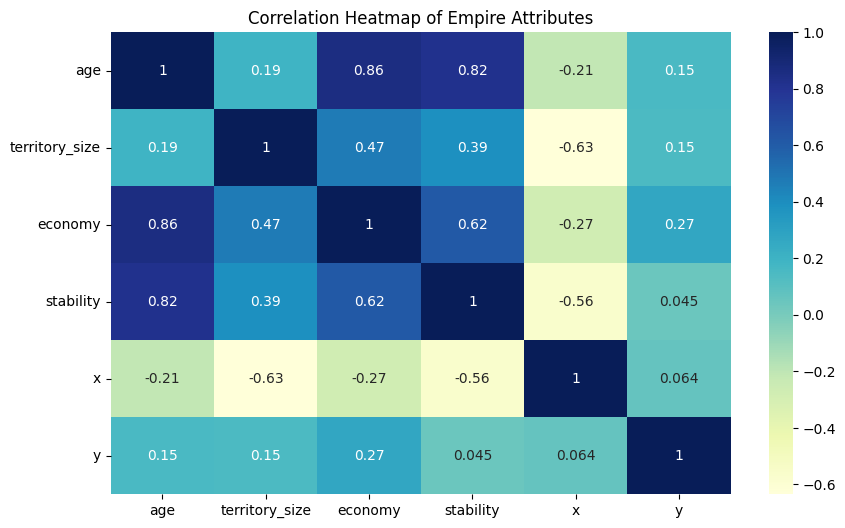

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
#metrics_df = spark.read.format("delta").load(delta_lake_path)
# Convert to Pandas for Seaborn compatibility
df = metrics_df.toPandas()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap of Empire Attributes")
plt.show()


In [0]:
from pyspark.sql.functions import col, desc
import plotly.express as px

# Query Delta table for visualization
# metrics_df = spark.read.format("delta").load(delta_table_path).orderBy(desc("Age"))

# Filter for a specific empire (optional)
empire_name = "Territory AI Empire"
empire_data = metrics_df.filter(col("empire_name") == empire_name).toPandas()

# Create a scatter plot of the empire's tiles
fig = px.scatter(
    empire_data,
    x="x",
    y="y",
    color="stability",
    title=f"Territory of {empire_name}",
    labels={"stability": "Stability"},
    hover_data=["economy", "age"]
)
fig.update_traces(marker=dict(symbol="hexagon", size=15))
fig.update_layout(
    xaxis=dict(title="X Coordinate"),
    yaxis=dict(title="Y Coordinate"),
    showlegend=True,
    plot_bgcolor="white",
)
fig.show()


In [0]:
# Add hexagonal positions to the DataFrame
# metrics_df = metrics_df.withColumn("col", col("x") * 1.5)  # Adjust spacing
# metrics_df = metrics_df.withColumn("row", col("y") * (3 ** 0.5))  # Vertical spacing based on hex geometry
metrics_df = metrics_df.fillna(0)
# Create a Plotly scatter plot with hexagonal shapes
fig = px.scatter(
    metrics_df.toPandas(),
    x="col",
    y="row",
    color="empire_name",
    size="economy",  # Bubble size for economy
    hover_data=["stability", "economy"],  # Add tooltips
    title="Civilization Map Visualization"
)

# Update layout to mimic a hexagonal map
fig.update_traces(marker=dict(symbol="hexagon"))
fig.update_layout(
    xaxis=dict(title="Map Columns", visible=False),
    yaxis=dict(title="Map Rows", visible=False),
    showlegend=True
)

fig.show()

In [0]:

# import mosaicml as mosaic
# empire_df = metrics_df.select("territory_size", "stability", "economy", "empire_name", "age")
# map_view = mosaic.create_map(empire_df, latitude_col="lat", longitude_col="long", region_col="empire_name")
# map_view.display()

In [0]:
# metrics_df = spark.read.format("delta").option("versionAsOf", 1).load(delta_lake_path)
# territory_size_chart = metrics_df.select("age", "empire_name", "territory_size")
# territory_size_chart.display()